# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [6]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

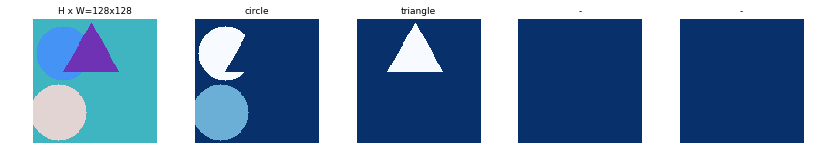

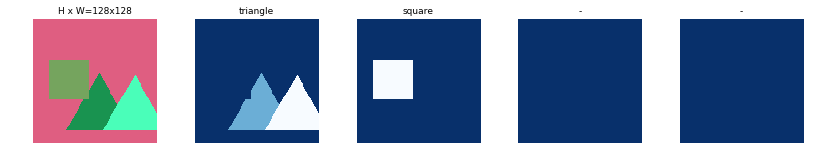

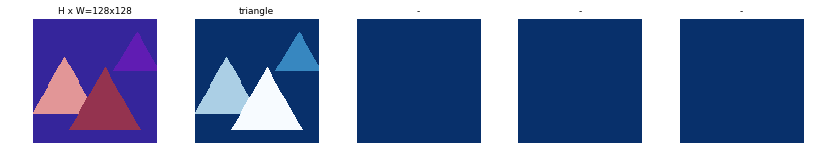

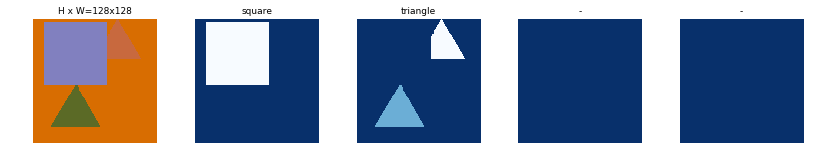

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\flohr\PythonProjects\MaskRCNN\Mask_RCNN\logs\shapes20180825T2136\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow\python\ops\gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1


C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  1/100 [..............................] - ETA: 11:58 - loss: 5.4552 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.8121 - mrcnn_class_loss: 1.5736 - mrcnn_bbox_loss: 1.2604 - mrcnn_mask_loss: 0.7329

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  2/100 [..............................] - ETA: 7:02 - loss: 5.5604 - rpn_class_loss: 0.0830 - rpn_bbox_loss: 2.1930 - mrcnn_class_loss: 1.3007 - mrcnn_bbox_loss: 1.2804 - mrcnn_mask_loss: 0.7033 

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  3/100 [..............................] - ETA: 5:17 - loss: 5.6099 - rpn_class_loss: 0.0958 - rpn_bbox_loss: 2.4417 - mrcnn_class_loss: 1.1832 - mrcnn_bbox_loss: 1.2469 - mrcnn_mask_loss: 0.6424

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  4/100 [>.............................] - ETA: 4:25 - loss: 5.4211 - rpn_class_loss: 0.0964 - rpn_bbox_loss: 2.2403 - mrcnn_class_loss: 1.1514 - mrcnn_bbox_loss: 1.2059 - mrcnn_mask_loss: 0.7272

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  5/100 [>.............................] - ETA: 3:54 - loss: 5.1150 - rpn_class_loss: 0.0905 - rpn_bbox_loss: 2.0274 - mrcnn_class_loss: 1.0654 - mrcnn_bbox_loss: 1.1622 - mrcnn_mask_loss: 0.7695

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  6/100 [>.............................] - ETA: 3:32 - loss: 4.8851 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 1.8591 - mrcnn_class_loss: 1.0502 - mrcnn_bbox_loss: 1.1312 - mrcnn_mask_loss: 0.7522

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  7/100 [=>............................] - ETA: 3:18 - loss: 4.7437 - rpn_class_loss: 0.0891 - rpn_bbox_loss: 1.7634 - mrcnn_class_loss: 1.0288 - mrcnn_bbox_loss: 1.0885 - mrcnn_mask_loss: 0.7739

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  8/100 [=>............................] - ETA: 3:08 - loss: 4.5257 - rpn_class_loss: 0.0858 - rpn_bbox_loss: 1.6549 - mrcnn_class_loss: 0.9696 - mrcnn_bbox_loss: 1.0666 - mrcnn_mask_loss: 0.7488

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  9/100 [=>............................] - ETA: 2:59 - loss: 4.3316 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 1.5466 - mrcnn_class_loss: 0.9220 - mrcnn_bbox_loss: 1.0393 - mrcnn_mask_loss: 0.7404

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 10/100 [==>...........................] - ETA: 2:51 - loss: 4.2019 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 1.4776 - mrcnn_class_loss: 0.8928 - mrcnn_bbox_loss: 1.0158 - mrcnn_mask_loss: 0.7337

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 11/100 [==>...........................] - ETA: 2:45 - loss: 4.0601 - rpn_class_loss: 0.0816 - rpn_bbox_loss: 1.4054 - mrcnn_class_loss: 0.8508 - mrcnn_bbox_loss: 0.9955 - mrcnn_mask_loss: 0.7267

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 12/100 [==>...........................] - ETA: 2:40 - loss: 3.9448 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 1.3592 - mrcnn_class_loss: 0.8202 - mrcnn_bbox_loss: 0.9688 - mrcnn_mask_loss: 0.7179

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 13/100 [==>...........................] - ETA: 2:35 - loss: 3.8160 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.2928 - mrcnn_class_loss: 0.7908 - mrcnn_bbox_loss: 0.9521 - mrcnn_mask_loss: 0.7048

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 14/100 [===>..........................] - ETA: 2:31 - loss: 3.7424 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.2710 - mrcnn_class_loss: 0.7685 - mrcnn_bbox_loss: 0.9315 - mrcnn_mask_loss: 0.6963

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 15/100 [===>..........................] - ETA: 2:27 - loss: 3.6423 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.2271 - mrcnn_class_loss: 0.7455 - mrcnn_bbox_loss: 0.9188 - mrcnn_mask_loss: 0.6772

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 16/100 [===>..........................] - ETA: 2:23 - loss: 3.5462 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 1.1826 - mrcnn_class_loss: 0.7226 - mrcnn_bbox_loss: 0.8943 - mrcnn_mask_loss: 0.6742

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 17/100 [====>.........................] - ETA: 2:20 - loss: 3.4777 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.1508 - mrcnn_class_loss: 0.7089 - mrcnn_bbox_loss: 0.8775 - mrcnn_mask_loss: 0.6685

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 18/100 [====>.........................] - ETA: 2:18 - loss: 3.4052 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.1233 - mrcnn_class_loss: 0.6896 - mrcnn_bbox_loss: 0.8612 - mrcnn_mask_loss: 0.6596

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 19/100 [====>.........................] - ETA: 2:16 - loss: 3.3281 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 1.0919 - mrcnn_class_loss: 0.6689 - mrcnn_bbox_loss: 0.8504 - mrcnn_mask_loss: 0.6473

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 20/100 [=====>........................] - ETA: 2:14 - loss: 3.2678 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 1.0715 - mrcnn_class_loss: 0.6508 - mrcnn_bbox_loss: 0.8403 - mrcnn_mask_loss: 0.6362

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 21/100 [=====>........................] - ETA: 2:11 - loss: 3.2421 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 1.0864 - mrcnn_class_loss: 0.6331 - mrcnn_bbox_loss: 0.8238 - mrcnn_mask_loss: 0.6309

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 22/100 [=====>........................] - ETA: 2:09 - loss: 3.1711 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 1.0620 - mrcnn_class_loss: 0.6149 - mrcnn_bbox_loss: 0.8056 - mrcnn_mask_loss: 0.6222

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 23/100 [=====>........................] - ETA: 2:06 - loss: 3.1145 - rpn_class_loss: 0.0653 - rpn_bbox_loss: 1.0451 - mrcnn_class_loss: 0.5991 - mrcnn_bbox_loss: 0.7887 - mrcnn_mask_loss: 0.6163

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 24/100 [======>.......................] - ETA: 2:03 - loss: 3.0809 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.0436 - mrcnn_class_loss: 0.5879 - mrcnn_bbox_loss: 0.7729 - mrcnn_mask_loss: 0.6120

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 25/100 [======>.......................] - ETA: 2:00 - loss: 3.0275 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.0246 - mrcnn_class_loss: 0.5747 - mrcnn_bbox_loss: 0.7578 - mrcnn_mask_loss: 0.6069

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 26/100 [======>.......................] - ETA: 1:57 - loss: 2.9860 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.0075 - mrcnn_class_loss: 0.5686 - mrcnn_bbox_loss: 0.7445 - mrcnn_mask_loss: 0.6028

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 27/100 [=======>......................] - ETA: 1:54 - loss: 2.9390 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.9867 - mrcnn_class_loss: 0.5591 - mrcnn_bbox_loss: 0.7338 - mrcnn_mask_loss: 0.5978

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 28/100 [=======>......................] - ETA: 1:51 - loss: 2.8993 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 0.9755 - mrcnn_class_loss: 0.5497 - mrcnn_bbox_loss: 0.7215 - mrcnn_mask_loss: 0.5917

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 29/100 [=======>......................] - ETA: 1:47 - loss: 2.8686 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 0.9716 - mrcnn_class_loss: 0.5418 - mrcnn_bbox_loss: 0.7095 - mrcnn_mask_loss: 0.5857

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 30/100 [========>.....................] - ETA: 1:44 - loss: 2.8342 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 0.9623 - mrcnn_class_loss: 0.5352 - mrcnn_bbox_loss: 0.6981 - mrcnn_mask_loss: 0.5793

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 31/100 [========>.....................] - ETA: 1:40 - loss: 2.7990 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 0.9517 - mrcnn_class_loss: 0.5279 - mrcnn_bbox_loss: 0.6862 - mrcnn_mask_loss: 0.5749

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 32/100 [========>.....................] - ETA: 1:37 - loss: 2.7570 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 0.9362 - mrcnn_class_loss: 0.5183 - mrcnn_bbox_loss: 0.6761 - mrcnn_mask_loss: 0.5691

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 33/100 [========>.....................] - ETA: 1:34 - loss: 2.7485 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 0.9469 - mrcnn_class_loss: 0.5104 - mrcnn_bbox_loss: 0.6685 - mrcnn_mask_loss: 0.5661

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 34/100 [=========>....................] - ETA: 1:31 - loss: 2.7127 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 0.9317 - mrcnn_class_loss: 0.5040 - mrcnn_bbox_loss: 0.6596 - mrcnn_mask_loss: 0.5617

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 35/100 [=========>....................] - ETA: 1:28 - loss: 2.6827 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 0.9179 - mrcnn_class_loss: 0.4992 - mrcnn_bbox_loss: 0.6509 - mrcnn_mask_loss: 0.5600

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 36/100 [=========>....................] - ETA: 1:26 - loss: 2.6469 - rpn_class_loss: 0.0542 - rpn_bbox_loss: 0.9029 - mrcnn_class_loss: 0.4934 - mrcnn_bbox_loss: 0.6418 - mrcnn_mask_loss: 0.5545

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 37/100 [==========>...................] - ETA: 1:23 - loss: 2.6162 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 0.8909 - mrcnn_class_loss: 0.4882 - mrcnn_bbox_loss: 0.6328 - mrcnn_mask_loss: 0.5508

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 38/100 [==========>...................] - ETA: 1:21 - loss: 2.5845 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 0.8793 - mrcnn_class_loss: 0.4815 - mrcnn_bbox_loss: 0.6240 - mrcnn_mask_loss: 0.5471

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 39/100 [==========>...................] - ETA: 1:18 - loss: 2.5549 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 0.8706 - mrcnn_class_loss: 0.4751 - mrcnn_bbox_loss: 0.6144 - mrcnn_mask_loss: 0.5428

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 40/100 [===========>..................] - ETA: 1:16 - loss: 2.5350 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 0.8635 - mrcnn_class_loss: 0.4722 - mrcnn_bbox_loss: 0.6065 - mrcnn_mask_loss: 0.5415

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 41/100 [===========>..................] - ETA: 1:14 - loss: 2.5074 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 0.8557 - mrcnn_class_loss: 0.4659 - mrcnn_bbox_loss: 0.5984 - mrcnn_mask_loss: 0.5367

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 42/100 [===========>..................] - ETA: 1:12 - loss: 2.4786 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 0.8464 - mrcnn_class_loss: 0.4595 - mrcnn_bbox_loss: 0.5906 - mrcnn_mask_loss: 0.5324

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 43/100 [===========>..................] - ETA: 1:10 - loss: 2.4580 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.8408 - mrcnn_class_loss: 0.4546 - mrcnn_bbox_loss: 0.5836 - mrcnn_mask_loss: 0.5298

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 44/100 [============>.................] - ETA: 1:08 - loss: 2.4275 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.8303 - mrcnn_class_loss: 0.4482 - mrcnn_bbox_loss: 0.5754 - mrcnn_mask_loss: 0.5252

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 45/100 [============>.................] - ETA: 1:06 - loss: 2.4027 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.8231 - mrcnn_class_loss: 0.4420 - mrcnn_bbox_loss: 0.5685 - mrcnn_mask_loss: 0.5213

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 46/100 [============>.................] - ETA: 1:05 - loss: 2.3844 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.8140 - mrcnn_class_loss: 0.4396 - mrcnn_bbox_loss: 0.5633 - mrcnn_mask_loss: 0.5201

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 47/100 [=============>................] - ETA: 1:03 - loss: 2.3551 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.8034 - mrcnn_class_loss: 0.4333 - mrcnn_bbox_loss: 0.5566 - mrcnn_mask_loss: 0.5150

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 48/100 [=============>................] - ETA: 1:01 - loss: 2.3375 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.7974 - mrcnn_class_loss: 0.4294 - mrcnn_bbox_loss: 0.5517 - mrcnn_mask_loss: 0.5127

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 49/100 [=============>................] - ETA: 59s - loss: 2.3174 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.7888 - mrcnn_class_loss: 0.4256 - mrcnn_bbox_loss: 0.5459 - mrcnn_mask_loss: 0.5116 

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 50/100 [==============>...............] - ETA: 58s - loss: 2.2945 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.7809 - mrcnn_class_loss: 0.4214 - mrcnn_bbox_loss: 0.5387 - mrcnn_mask_loss: 0.5083

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 51/100 [==============>...............] - ETA: 56s - loss: 2.2791 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 0.7747 - mrcnn_class_loss: 0.4187 - mrcnn_bbox_loss: 0.5348 - mrcnn_mask_loss: 0.5064

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 52/100 [==============>...............] - ETA: 55s - loss: 2.2607 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.7670 - mrcnn_class_loss: 0.4161 - mrcnn_bbox_loss: 0.5301 - mrcnn_mask_loss: 0.5034

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 53/100 [==============>...............] - ETA: 53s - loss: 2.2433 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.7589 - mrcnn_class_loss: 0.4136 - mrcnn_bbox_loss: 0.5260 - mrcnn_mask_loss: 0.5011

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 54/100 [===============>..............] - ETA: 52s - loss: 2.2244 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.7517 - mrcnn_class_loss: 0.4103 - mrcnn_bbox_loss: 0.5216 - mrcnn_mask_loss: 0.4975

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 55/100 [===============>..............] - ETA: 50s - loss: 2.2043 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.7448 - mrcnn_class_loss: 0.4071 - mrcnn_bbox_loss: 0.5158 - mrcnn_mask_loss: 0.4939

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 56/100 [===============>..............] - ETA: 49s - loss: 2.1908 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.7419 - mrcnn_class_loss: 0.4036 - mrcnn_bbox_loss: 0.5123 - mrcnn_mask_loss: 0.4907

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 57/100 [================>.............] - ETA: 47s - loss: 2.1740 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.7362 - mrcnn_class_loss: 0.4008 - mrcnn_bbox_loss: 0.5071 - mrcnn_mask_loss: 0.4881

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 58/100 [================>.............] - ETA: 46s - loss: 2.1580 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.7311 - mrcnn_class_loss: 0.3980 - mrcnn_bbox_loss: 0.5027 - mrcnn_mask_loss: 0.4849

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 59/100 [================>.............] - ETA: 45s - loss: 2.1417 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.7259 - mrcnn_class_loss: 0.3947 - mrcnn_bbox_loss: 0.4984 - mrcnn_mask_loss: 0.4818

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 60/100 [=================>............] - ETA: 43s - loss: 2.1260 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.7213 - mrcnn_class_loss: 0.3913 - mrcnn_bbox_loss: 0.4935 - mrcnn_mask_loss: 0.4794

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 61/100 [=================>............] - ETA: 42s - loss: 2.1124 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.7173 - mrcnn_class_loss: 0.3882 - mrcnn_bbox_loss: 0.4900 - mrcnn_mask_loss: 0.4767

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 62/100 [=================>............] - ETA: 41s - loss: 2.0991 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.7140 - mrcnn_class_loss: 0.3860 - mrcnn_bbox_loss: 0.4858 - mrcnn_mask_loss: 0.4734

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 63/100 [=================>............] - ETA: 39s - loss: 2.0879 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.7110 - mrcnn_class_loss: 0.3838 - mrcnn_bbox_loss: 0.4823 - mrcnn_mask_loss: 0.4713

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 64/100 [==================>...........] - ETA: 38s - loss: 2.0739 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.7060 - mrcnn_class_loss: 0.3816 - mrcnn_bbox_loss: 0.4784 - mrcnn_mask_loss: 0.4687

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 65/100 [==================>...........] - ETA: 37s - loss: 2.0598 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.7012 - mrcnn_class_loss: 0.3793 - mrcnn_bbox_loss: 0.4751 - mrcnn_mask_loss: 0.4654

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 66/100 [==================>...........] - ETA: 36s - loss: 2.0478 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.6965 - mrcnn_class_loss: 0.3769 - mrcnn_bbox_loss: 0.4724 - mrcnn_mask_loss: 0.4634

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 67/100 [===================>..........] - ETA: 35s - loss: 2.0336 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.6916 - mrcnn_class_loss: 0.3754 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.4602

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 68/100 [===================>..........] - ETA: 33s - loss: 2.0256 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.6882 - mrcnn_class_loss: 0.3753 - mrcnn_bbox_loss: 0.4649 - mrcnn_mask_loss: 0.4593

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 69/100 [===================>..........] - ETA: 32s - loss: 2.0128 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.6836 - mrcnn_class_loss: 0.3733 - mrcnn_bbox_loss: 0.4616 - mrcnn_mask_loss: 0.4567

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 70/100 [====================>.........] - ETA: 31s - loss: 2.0007 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6793 - mrcnn_class_loss: 0.3714 - mrcnn_bbox_loss: 0.4579 - mrcnn_mask_loss: 0.4548

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 71/100 [====================>.........] - ETA: 30s - loss: 1.9898 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.6754 - mrcnn_class_loss: 0.3705 - mrcnn_bbox_loss: 0.4547 - mrcnn_mask_loss: 0.4522

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 72/100 [====================>.........] - ETA: 29s - loss: 1.9751 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.6704 - mrcnn_class_loss: 0.3671 - mrcnn_bbox_loss: 0.4511 - mrcnn_mask_loss: 0.4497

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 73/100 [====================>.........] - ETA: 28s - loss: 1.9600 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.6662 - mrcnn_class_loss: 0.3638 - mrcnn_bbox_loss: 0.4469 - mrcnn_mask_loss: 0.4466

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 74/100 [=====================>........] - ETA: 27s - loss: 1.9472 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.6613 - mrcnn_class_loss: 0.3613 - mrcnn_bbox_loss: 0.4440 - mrcnn_mask_loss: 0.4444

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 75/100 [=====================>........] - ETA: 26s - loss: 1.9328 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.6576 - mrcnn_class_loss: 0.3578 - mrcnn_bbox_loss: 0.4401 - mrcnn_mask_loss: 0.4416

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 76/100 [=====================>........] - ETA: 24s - loss: 1.9226 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.6549 - mrcnn_class_loss: 0.3562 - mrcnn_bbox_loss: 0.4371 - mrcnn_mask_loss: 0.4389

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 77/100 [======================>.......] - ETA: 23s - loss: 1.9084 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.6513 - mrcnn_class_loss: 0.3530 - mrcnn_bbox_loss: 0.4333 - mrcnn_mask_loss: 0.4356

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 78/100 [======================>.......] - ETA: 22s - loss: 1.8984 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.6493 - mrcnn_class_loss: 0.3512 - mrcnn_bbox_loss: 0.4299 - mrcnn_mask_loss: 0.4330

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 79/100 [======================>.......] - ETA: 21s - loss: 1.8865 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.6464 - mrcnn_class_loss: 0.3480 - mrcnn_bbox_loss: 0.4263 - mrcnn_mask_loss: 0.4310

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 80/100 [=======================>......] - ETA: 20s - loss: 1.8744 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.6434 - mrcnn_class_loss: 0.3454 - mrcnn_bbox_loss: 0.4231 - mrcnn_mask_loss: 0.4279

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 81/100 [=======================>......] - ETA: 19s - loss: 1.8633 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.6411 - mrcnn_class_loss: 0.3426 - mrcnn_bbox_loss: 0.4201 - mrcnn_mask_loss: 0.4251

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 82/100 [=======================>......] - ETA: 18s - loss: 1.8518 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.6380 - mrcnn_class_loss: 0.3401 - mrcnn_bbox_loss: 0.4171 - mrcnn_mask_loss: 0.4224

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 83/100 [=======================>......] - ETA: 17s - loss: 1.8429 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.6358 - mrcnn_class_loss: 0.3384 - mrcnn_bbox_loss: 0.4147 - mrcnn_mask_loss: 0.4201

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 84/100 [========================>.....] - ETA: 16s - loss: 1.8315 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.6335 - mrcnn_class_loss: 0.3355 - mrcnn_bbox_loss: 0.4115 - mrcnn_mask_loss: 0.4173

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 85/100 [========================>.....] - ETA: 15s - loss: 1.8189 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.6295 - mrcnn_class_loss: 0.3332 - mrcnn_bbox_loss: 0.4082 - mrcnn_mask_loss: 0.4145

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 86/100 [========================>.....] - ETA: 14s - loss: 1.8092 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.6269 - mrcnn_class_loss: 0.3317 - mrcnn_bbox_loss: 0.4056 - mrcnn_mask_loss: 0.4117

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 87/100 [=========================>....] - ETA: 13s - loss: 1.8002 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.6244 - mrcnn_class_loss: 0.3296 - mrcnn_bbox_loss: 0.4034 - mrcnn_mask_loss: 0.4098

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 88/100 [=========================>....] - ETA: 12s - loss: 1.7917 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.6216 - mrcnn_class_loss: 0.3287 - mrcnn_bbox_loss: 0.4012 - mrcnn_mask_loss: 0.4073

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 89/100 [=========================>....] - ETA: 11s - loss: 1.7840 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.6200 - mrcnn_class_loss: 0.3269 - mrcnn_bbox_loss: 0.3990 - mrcnn_mask_loss: 0.4053

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 90/100 [==========================>...] - ETA: 10s - loss: 1.7744 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.6178 - mrcnn_class_loss: 0.3248 - mrcnn_bbox_loss: 0.3968 - mrcnn_mask_loss: 0.4025

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 91/100 [==========================>...] - ETA: 9s - loss: 1.7661 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.6155 - mrcnn_class_loss: 0.3231 - mrcnn_bbox_loss: 0.3952 - mrcnn_mask_loss: 0.4000 

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 92/100 [==========================>...] - ETA: 8s - loss: 1.7595 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.6139 - mrcnn_class_loss: 0.3225 - mrcnn_bbox_loss: 0.3932 - mrcnn_mask_loss: 0.3977

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 93/100 [==========================>...] - ETA: 7s - loss: 1.7516 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.6122 - mrcnn_class_loss: 0.3206 - mrcnn_bbox_loss: 0.3912 - mrcnn_mask_loss: 0.3956

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 94/100 [===========================>..] - ETA: 6s - loss: 1.7454 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.6110 - mrcnn_class_loss: 0.3196 - mrcnn_bbox_loss: 0.3893 - mrcnn_mask_loss: 0.3937

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 95/100 [===========================>..] - ETA: 5s - loss: 1.7359 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.6086 - mrcnn_class_loss: 0.3171 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.3914

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 96/100 [===========================>..] - ETA: 4s - loss: 1.7289 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.6067 - mrcnn_class_loss: 0.3159 - mrcnn_bbox_loss: 0.3854 - mrcnn_mask_loss: 0.3895

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 97/100 [============================>.] - ETA: 3s - loss: 1.7239 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.6051 - mrcnn_class_loss: 0.3144 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.3890

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 98/100 [============================>.] - ETA: 2s - loss: 1.7159 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.6028 - mrcnn_class_loss: 0.3126 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.3870

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 99/100 [============================>.] - ETA: 1s - loss: 1.7069 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.6007 - mrcnn_class_loss: 0.3108 - mrcnn_bbox_loss: 0.3798 - mrcnn_mask_loss: 0.3846

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

100/100 [==============================] - 105s 1s/step - loss: 1.6991 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.5982 - mrcnn_class_loss: 0.3094 - mrcnn_bbox_loss: 0.3783 - mrcnn_mask_loss: 0.3824 - val_loss: 1.0536 - val_rpn_class_loss: 0.0138 - val_rpn_bbox_loss: 0.4552 - val_mrcnn_class_loss: 0.2012 - val_mrcnn_bbox_loss: 0.2021 - val_mrcnn_mask_loss: 0.1813


In [11]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\flohr\PythonProjects\MaskRCNN\Mask_RCNN\logs\shapes20180825T2136\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow\python\ops\gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/2


C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  1/100 [..............................] - ETA: 18:00 - loss: 0.6617 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.2876 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.1610 - mrcnn_mask_loss: 0.1350

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  2/100 [..............................] - ETA: 9:48 - loss: 0.7343 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.3183 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.1485 - mrcnn_mask_loss: 0.1499 

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  3/100 [..............................] - ETA: 7:04 - loss: 0.8285 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.3420 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.1670 - mrcnn_mask_loss: 0.1566

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  4/100 [>.............................] - ETA: 5:44 - loss: 0.7934 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.3394 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.1536

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  5/100 [>.............................] - ETA: 4:54 - loss: 0.8237 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.3425 - mrcnn_class_loss: 0.1263 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.1658

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  6/100 [>.............................] - ETA: 4:20 - loss: 0.8623 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.3623 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.1756 - mrcnn_mask_loss: 0.1707

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  7/100 [=>............................] - ETA: 3:54 - loss: 0.8495 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.3665 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.1691 - mrcnn_mask_loss: 0.1653

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  8/100 [=>............................] - ETA: 3:38 - loss: 0.8481 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.3673 - mrcnn_class_loss: 0.1360 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.1621

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

  9/100 [=>............................] - ETA: 3:24 - loss: 0.8745 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.3695 - mrcnn_class_loss: 0.1487 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.1677

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 10/100 [==>...........................] - ETA: 3:11 - loss: 0.8593 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.3649 - mrcnn_class_loss: 0.1443 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.1653

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 11/100 [==>...........................] - ETA: 3:01 - loss: 0.8564 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.3606 - mrcnn_class_loss: 0.1445 - mrcnn_bbox_loss: 0.1664 - mrcnn_mask_loss: 0.1682

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 12/100 [==>...........................] - ETA: 2:52 - loss: 0.8636 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.3613 - mrcnn_class_loss: 0.1453 - mrcnn_bbox_loss: 0.1663 - mrcnn_mask_loss: 0.1745

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 13/100 [==>...........................] - ETA: 2:46 - loss: 0.8587 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.3633 - mrcnn_class_loss: 0.1437 - mrcnn_bbox_loss: 0.1628 - mrcnn_mask_loss: 0.1725

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 14/100 [===>..........................] - ETA: 2:39 - loss: 0.8519 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.3617 - mrcnn_class_loss: 0.1416 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.1714

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 15/100 [===>..........................] - ETA: 2:33 - loss: 0.8551 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.3656 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.1603 - mrcnn_mask_loss: 0.1721

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 16/100 [===>..........................] - ETA: 2:28 - loss: 0.8720 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.3709 - mrcnn_class_loss: 0.1427 - mrcnn_bbox_loss: 0.1639 - mrcnn_mask_loss: 0.1783

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 17/100 [====>.........................] - ETA: 2:23 - loss: 0.8818 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.3698 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.1664 - mrcnn_mask_loss: 0.1824

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 18/100 [====>.........................] - ETA: 2:19 - loss: 0.8907 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.3784 - mrcnn_class_loss: 0.1464 - mrcnn_bbox_loss: 0.1670 - mrcnn_mask_loss: 0.1820

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 19/100 [====>.........................] - ETA: 2:15 - loss: 0.8818 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.3800 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.1643 - mrcnn_mask_loss: 0.1781

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 20/100 [=====>........................] - ETA: 2:11 - loss: 0.8805 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.3867 - mrcnn_class_loss: 0.1392 - mrcnn_bbox_loss: 0.1627 - mrcnn_mask_loss: 0.1754

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 21/100 [=====>........................] - ETA: 2:08 - loss: 0.8783 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.3867 - mrcnn_class_loss: 0.1387 - mrcnn_bbox_loss: 0.1610 - mrcnn_mask_loss: 0.1752

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 22/100 [=====>........................] - ETA: 2:04 - loss: 0.8842 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.3901 - mrcnn_class_loss: 0.1391 - mrcnn_bbox_loss: 0.1621 - mrcnn_mask_loss: 0.1762

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 23/100 [=====>........................] - ETA: 2:01 - loss: 0.8882 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.3950 - mrcnn_class_loss: 0.1414 - mrcnn_bbox_loss: 0.1605 - mrcnn_mask_loss: 0.1747

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 24/100 [======>.......................] - ETA: 1:58 - loss: 0.8906 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.3938 - mrcnn_class_loss: 0.1435 - mrcnn_bbox_loss: 0.1619 - mrcnn_mask_loss: 0.1750

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 25/100 [======>.......................] - ETA: 1:55 - loss: 0.8912 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.3908 - mrcnn_class_loss: 0.1433 - mrcnn_bbox_loss: 0.1633 - mrcnn_mask_loss: 0.1774

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 26/100 [======>.......................] - ETA: 1:53 - loss: 0.9005 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.3922 - mrcnn_class_loss: 0.1437 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.1827

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 27/100 [=======>......................] - ETA: 1:50 - loss: 0.8966 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.3923 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.1803

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 28/100 [=======>......................] - ETA: 1:47 - loss: 0.8915 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.3914 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.1623 - mrcnn_mask_loss: 0.1800

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 29/100 [=======>......................] - ETA: 1:45 - loss: 0.8905 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.3915 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.1608 - mrcnn_mask_loss: 0.1801

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 30/100 [========>.....................] - ETA: 1:43 - loss: 0.8902 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.3912 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.1618 - mrcnn_mask_loss: 0.1789

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 31/100 [========>.....................] - ETA: 1:40 - loss: 0.8841 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.3879 - mrcnn_class_loss: 0.1408 - mrcnn_bbox_loss: 0.1601 - mrcnn_mask_loss: 0.1787

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 32/100 [========>.....................] - ETA: 1:38 - loss: 0.8826 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.3889 - mrcnn_class_loss: 0.1407 - mrcnn_bbox_loss: 0.1591 - mrcnn_mask_loss: 0.1774

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 33/100 [========>.....................] - ETA: 1:36 - loss: 0.8812 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.3893 - mrcnn_class_loss: 0.1404 - mrcnn_bbox_loss: 0.1589 - mrcnn_mask_loss: 0.1761

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 34/100 [=========>....................] - ETA: 1:34 - loss: 0.8844 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.3929 - mrcnn_class_loss: 0.1386 - mrcnn_bbox_loss: 0.1589 - mrcnn_mask_loss: 0.1778

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 35/100 [=========>....................] - ETA: 1:32 - loss: 0.8783 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.3920 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1582 - mrcnn_mask_loss: 0.1757

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 36/100 [=========>....................] - ETA: 1:30 - loss: 0.8723 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.3908 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.1740

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 37/100 [==========>...................] - ETA: 1:28 - loss: 0.8733 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.3942 - mrcnn_class_loss: 0.1351 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.1728

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 38/100 [==========>...................] - ETA: 1:26 - loss: 0.8720 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.3941 - mrcnn_class_loss: 0.1360 - mrcnn_bbox_loss: 0.1539 - mrcnn_mask_loss: 0.1717

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 39/100 [==========>...................] - ETA: 1:25 - loss: 0.8718 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.3949 - mrcnn_class_loss: 0.1357 - mrcnn_bbox_loss: 0.1532 - mrcnn_mask_loss: 0.1717

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 40/100 [===========>..................] - ETA: 1:23 - loss: 0.8683 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.3964 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.1514 - mrcnn_mask_loss: 0.1706

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 41/100 [===========>..................] - ETA: 1:21 - loss: 0.8711 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.3982 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.1511 - mrcnn_mask_loss: 0.1710

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 42/100 [===========>..................] - ETA: 1:20 - loss: 0.8740 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.3994 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.1516 - mrcnn_mask_loss: 0.1722

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 43/100 [===========>..................] - ETA: 1:18 - loss: 0.8711 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.3982 - mrcnn_class_loss: 0.1334 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.1719

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 44/100 [============>.................] - ETA: 1:16 - loss: 0.8688 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.3973 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.1711

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 45/100 [============>.................] - ETA: 1:15 - loss: 0.8688 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.3991 - mrcnn_class_loss: 0.1334 - mrcnn_bbox_loss: 0.1492 - mrcnn_mask_loss: 0.1709

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 46/100 [============>.................] - ETA: 1:13 - loss: 0.8655 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.3997 - mrcnn_class_loss: 0.1318 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.1702

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 47/100 [=============>................] - ETA: 1:11 - loss: 0.8680 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4016 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 0.1701

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 48/100 [=============>................] - ETA: 1:10 - loss: 0.8696 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.1327 - mrcnn_bbox_loss: 0.1487 - mrcnn_mask_loss: 0.1697

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 49/100 [=============>................] - ETA: 1:08 - loss: 0.8647 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4006 - mrcnn_class_loss: 0.1325 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.1683

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 50/100 [==============>...............] - ETA: 1:07 - loss: 0.8643 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4022 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.1673

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 51/100 [==============>...............] - ETA: 1:05 - loss: 0.8623 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4015 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.1666

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 52/100 [==============>...............] - ETA: 1:03 - loss: 0.8631 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4029 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.1661

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 53/100 [==============>...............] - ETA: 1:02 - loss: 0.8654 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4050 - mrcnn_class_loss: 0.1325 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.1658

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 54/100 [===============>..............] - ETA: 1:01 - loss: 0.8607 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4042 - mrcnn_class_loss: 0.1310 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.1647

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 55/100 [===============>..............] - ETA: 59s - loss: 0.8598 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4046 - mrcnn_class_loss: 0.1306 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.1642 

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 56/100 [===============>..............] - ETA: 58s - loss: 0.8596 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.1635

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 57/100 [================>.............] - ETA: 56s - loss: 0.8563 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4043 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.1625

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 58/100 [================>.............] - ETA: 55s - loss: 0.8568 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4046 - mrcnn_class_loss: 0.1305 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.1624

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 59/100 [================>.............] - ETA: 54s - loss: 0.8561 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4046 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.1621

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 60/100 [=================>............] - ETA: 52s - loss: 0.8538 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4036 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1612

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 61/100 [=================>............] - ETA: 51s - loss: 0.8548 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4043 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1611

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 62/100 [=================>............] - ETA: 49s - loss: 0.8515 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4027 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.1610

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 63/100 [=================>............] - ETA: 48s - loss: 0.8523 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.1302 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.1616

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 64/100 [==================>...........] - ETA: 47s - loss: 0.8507 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4027 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1607

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 65/100 [==================>...........] - ETA: 45s - loss: 0.8483 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4025 - mrcnn_class_loss: 0.1289 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1600

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 66/100 [==================>...........] - ETA: 44s - loss: 0.8487 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4020 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1605

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 67/100 [===================>..........] - ETA: 42s - loss: 0.8516 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.1621

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 68/100 [===================>..........] - ETA: 41s - loss: 0.8500 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4015 - mrcnn_class_loss: 0.1295 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.1618

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 69/100 [===================>..........] - ETA: 40s - loss: 0.8525 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4026 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1625

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 70/100 [====================>.........] - ETA: 38s - loss: 0.8512 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4027 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.1615

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 71/100 [====================>.........] - ETA: 37s - loss: 0.8503 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4026 - mrcnn_class_loss: 0.1295 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1614

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 72/100 [====================>.........] - ETA: 36s - loss: 0.8490 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4031 - mrcnn_class_loss: 0.1286 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.1607

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 73/100 [====================>.........] - ETA: 34s - loss: 0.8503 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4039 - mrcnn_class_loss: 0.1286 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.1607

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 74/100 [=====================>........] - ETA: 33s - loss: 0.8506 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4061 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.1602

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 75/100 [=====================>........] - ETA: 32s - loss: 0.8491 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4049 - mrcnn_class_loss: 0.1279 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.1599

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 76/100 [=====================>........] - ETA: 30s - loss: 0.8484 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4051 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.1399 - mrcnn_mask_loss: 0.1598

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 77/100 [======================>.......] - ETA: 29s - loss: 0.8465 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4041 - mrcnn_class_loss: 0.1271 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.1596

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 78/100 [======================>.......] - ETA: 28s - loss: 0.8469 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4039 - mrcnn_class_loss: 0.1272 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.1601

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 79/100 [======================>.......] - ETA: 26s - loss: 0.8452 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4029 - mrcnn_class_loss: 0.1269 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.1599

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 80/100 [=======================>......] - ETA: 25s - loss: 0.8439 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4020 - mrcnn_class_loss: 0.1271 - mrcnn_bbox_loss: 0.1389 - mrcnn_mask_loss: 0.1599

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 81/100 [=======================>......] - ETA: 24s - loss: 0.8431 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4020 - mrcnn_class_loss: 0.1270 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.1593

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 82/100 [=======================>......] - ETA: 23s - loss: 0.8446 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4021 - mrcnn_class_loss: 0.1276 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.1599

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 83/100 [=======================>......] - ETA: 21s - loss: 0.8446 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4019 - mrcnn_class_loss: 0.1279 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.1597

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 84/100 [========================>.....] - ETA: 20s - loss: 0.8450 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4029 - mrcnn_class_loss: 0.1276 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.1597

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 85/100 [========================>.....] - ETA: 19s - loss: 0.8455 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4040 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.1385 - mrcnn_mask_loss: 0.1593

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 86/100 [========================>.....] - ETA: 17s - loss: 0.8478 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4044 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.1607

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 87/100 [=========================>....] - ETA: 16s - loss: 0.8482 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4051 - mrcnn_class_loss: 0.1274 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.1607

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 88/100 [=========================>....] - ETA: 15s - loss: 0.8476 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4050 - mrcnn_class_loss: 0.1269 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.1608

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 89/100 [=========================>....] - ETA: 13s - loss: 0.8457 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4042 - mrcnn_class_loss: 0.1265 - mrcnn_bbox_loss: 0.1384 - mrcnn_mask_loss: 0.1606

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 90/100 [==========================>...] - ETA: 12s - loss: 0.8452 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4051 - mrcnn_class_loss: 0.1264 - mrcnn_bbox_loss: 0.1378 - mrcnn_mask_loss: 0.1599

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 91/100 [==========================>...] - ETA: 11s - loss: 0.8436 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4046 - mrcnn_class_loss: 0.1260 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.1596

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 92/100 [==========================>...] - ETA: 10s - loss: 0.8423 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4047 - mrcnn_class_loss: 0.1257 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1591

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 93/100 [==========================>...] - ETA: 8s - loss: 0.8399 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4041 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.1361 - mrcnn_mask_loss: 0.1585 

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 94/100 [===========================>..] - ETA: 7s - loss: 0.8398 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4041 - mrcnn_class_loss: 0.1251 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.1583

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 95/100 [===========================>..] - ETA: 6s - loss: 0.8392 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.1249 - mrcnn_bbox_loss: 0.1356 - mrcnn_mask_loss: 0.1579

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 96/100 [===========================>..] - ETA: 5s - loss: 0.8408 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.1258 - mrcnn_bbox_loss: 0.1359 - mrcnn_mask_loss: 0.1582

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 97/100 [============================>.] - ETA: 3s - loss: 0.8384 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4038 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.1357 - mrcnn_mask_loss: 0.1576

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 98/100 [============================>.] - ETA: 2s - loss: 0.8378 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4036 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.1356 - mrcnn_mask_loss: 0.1573

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

 99/100 [============================>.] - ETA: 1s - loss: 0.8372 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4038 - mrcnn_class_loss: 0.1251 - mrcnn_bbox_loss: 0.1353 - mrcnn_mask_loss: 0.1570

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

100/100 [==============================] - 132s 1s/step - loss: 0.8356 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4033 - mrcnn_class_loss: 0.1250 - mrcnn_bbox_loss: 0.1348 - mrcnn_mask_loss: 0.1565 - val_loss: 0.8900 - val_rpn_class_loss: 0.0149 - val_rpn_bbox_loss: 0.4230 - val_mrcnn_class_loss: 0.1846 - val_mrcnn_bbox_loss: 0.1250 - val_mrcnn_mask_loss: 0.1425


In [12]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [16]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\flohr\PythonProjects\MaskRCNN\Mask_RCNN\logs\shapes20180825T2211\mask_rcnn_shapes_0002.h5


original_image           shape: (128, 128, 3)         min:    5.00000  max:  242.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (2,)                  min:    2.00000  max:    3.00000  int32
gt_bbox                  shape: (2, 4)                min:   24.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  bool


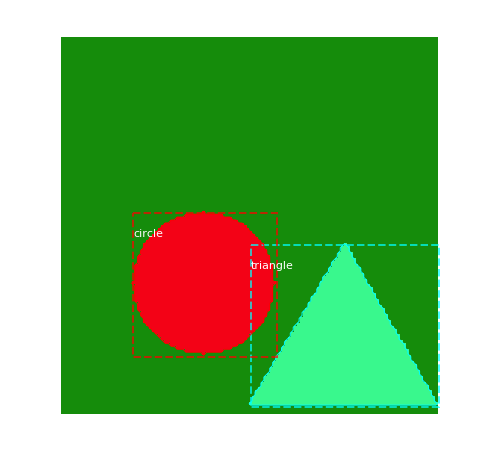

In [17]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    5.00000  max:  242.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -111.80000  max:  125.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


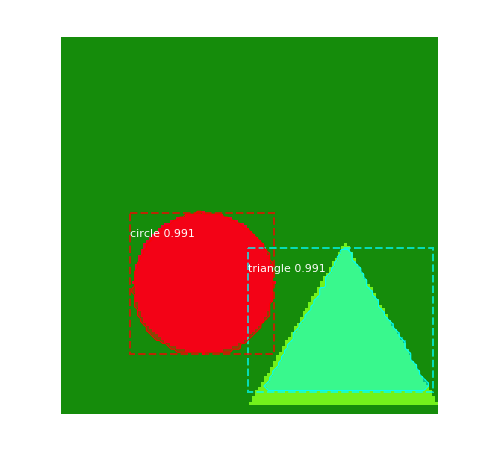

In [18]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [19]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default i

mAP:  0.9333333373069763


C:\Users\flohr\Anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
